<a href="https://colab.research.google.com/github/AndrewstheBuilder/FromScratch_NeuralNetworks/blob/main/MultiLayerPerceptron_FromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

import copy

np.random.seed(1)

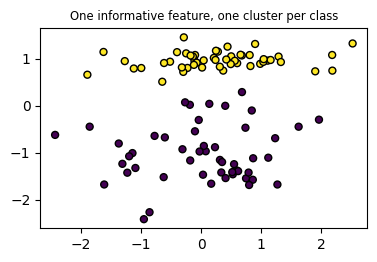

In [3]:
# Display Dataset to Train

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

plt.subplot(321)
plt.title("One informative feature, one cluster per class", fontsize="small")
X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1
)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

# Import Dataset to Train
train_length = int(len(X1) * 0.8)
test_length = len(X1) - train_length
train_x, test_x, train_y, test_y = X1[0:train_length], X1[train_length:], Y1[0:train_length], Y1[train_length:]
# print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

### Perceptron Micrograd Implementation

In [4]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        # print('__add__ self',self)
        # print('__add__ other',other)
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        # print('out',out)

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(x):
      if(x.data<=0):
        return Value(0)
      return Value(1)

    # def relu(self):
    #     out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    #     def _backward():
    #         self.grad += (out.data > 0) * out.grad
    #     out._backward = _backward

    #     return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [5]:
# Multi Layer Perceptron Implementation
class Neuron:
  '''
  '''
  def __init__(self, nin, nonlin=True):
        self.w = [Value(value)for value in np.random.randn(nin)]
        self.b = Value(np.random.randn(1))
        self.nonlin = nonlin

  def __call__(self, x):
      act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
      return act.relu() if self.nonlin else act

  def parameters(self):
      return self.w + [self.b]

  def __repr__(self):
      return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

  def backward(self,x,error,lr=0.001):
    '''
    Define Neuron's backward as Perceptron convergence theorem
    '''
    for i in range(len(self.w)):
        self.w[i] += x[i]*lr*error
    self.b += lr*error

In [6]:
w = Value(10)
w += 1.5 * 3.3 * 5.2
x = Value(10)
x += Value(1.5) * Value(3.3) * Value(5.2)

# First Attempt at solving this dataset with a Multi-Layer Perceptron(MLP)(turned into just being Perceptron)

- I can attempt to solve this as a regression problem first
- Take in X and try to predict the Y for the 100 examples of [Xi, Yi] that I have. It will find the line separating the two classes I believe!
- And after that I can try it as a classification problem.
- Then solve the MNIST dataset with my MLP
- Then try to do it with a different architecture like KANs

### Draft 1 **Perceptron**: Has backpropagation for learning but its adjusting the weights and biases without taking into account the error and what direction we should be adjusting the weights in.
- This setup allows the ML algorithm to learn any linear 2 variable function.

In [7]:
# Initialize weights start with the same values
weights = [1,1]
bias = 1

def relu(x):
  # if(x<=0):
  #   return 0
  # return 1
  return max(0, x)

def relu_deriv(output_relu):
  if(output_relu>=0):
    return 1
  return 0

weights = [1,1]
bias = 1
# n = Neuron(weights, None)
m = len(train_x)
iterations = 500
for n in range(iterations):
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2+ bias
    # Perform Loss Calculation
    error = (train_y[i] - output)
    # print('train_y[i]',train_y[i])
    # print('output',output)
    # Perform Back propagation to adjust the weight and bias
    weights[0] += -1 * x1
    weights[1] += -1 * x2
    bias += -1
  if(n%100 == 0):
    print('n:'+str(n)+' error:'+str(error))
# print(n)
# This implementation has the problem of exploding weights.
# I believe its because we are not taking into account the error. So we are adjusting
# the weight in the wrong direction

n:0 error:77.968865027191
n:100 error:8146.8367884085055
n:200 error:16215.704711789818
n:300 error:24284.572635171124
n:400 error:32353.440558552433


### Draft 2 **Perceptron**: There is no breaking symmetry here because the weights start out at the same value. But we introduce relu activation and use the error and learning rate to determine which direction and how much to adjust the weights and bias by.
- With a bias the weights start to cancel each other out and the bias starts to dominate the output
- Without a bias the weights find a equilibrium that leds to a inefficient solution. Its stuck in a pit. Forgot what this concept is called...

In [8]:
# Initialize weights start with the same values
weights = [1,1]
bias = 1

def relu(x):
  # if(x<=0):
  #   return 0
  # return 1
  return max(0, x)

def relu_deriv(output_relu):
  if(output_relu>=0):
    return 1
  return 0

m = len(train_x)
print('len(train_x)',m)
iterations = 500
lr = 0.001
for n in range(iterations):
  correct = 0
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2 + bias
    output_relu = relu(output)
    # Perform Loss Calculation
    error = (train_y[i] - output_relu)
    # print('error',error)
    if(error<0.5 and error > -0.5):
      correct += 1
    # Perform Back propagation to adjust the weight and bias
    weights[0] -= -1 * relu_deriv(output_relu) * x1 * lr * error
    weights[1] -= -1 * relu_deriv(output_relu) * x2 * lr * error
    bias += -1 * relu_deriv(output_relu) * lr * error
  if(n%10 == 0):
    print('----'*10)
    print('At the end of iteration:')
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',weights)
    print('bias',bias)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)
    # print('----'*10)
# print(n)

len(train_x) 80
----------------------------------------
At the end of iteration:
n:0 Train Accuracy:0.425
weights [0.9397506606690542, 0.9604537182731527]
bias 1.0674530955249053
Sample input [ 0.03261455 -1.46754119]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -0.3114027538014257
----------------------------------------
At the end of iteration:
n:10 Train Accuracy:0.05
weights [0.4074570719984095, 0.6217372564882174]
bias 1.9332814298511023
Sample input [ 0.03261455 -1.46754119]
Sample output f(x)=w1*x1 + w2*x2 + b -->  1.0353409758016214
----------------------------------------
At the end of iteration:
n:20 Train Accuracy:0.0
weights [0.07423968584174895, 0.4793706469672231]
bias 3.6988118602957596
Sample input [ 0.03261455 -1.46754119]
Sample output f(x)=w1*x1 + w2*x2 + b -->  3.0012025962883513
----------------------------------------
At the end of iteration:
n:30 Train Accuracy:0.0
weights [-0.20089688919013216, 0.45238527929174654]
bias 7.600876118036612
Sample input [ 0.03261455 

### Draft 3 **Perceptron**: Introducing Breaking Symmetry
* By initializing weights and bias randomly
* It seems like now the bias has grown to cancel out the weights contribution. Its not immediately clear what breaking the symmetry has done. I wonder how they discovered this concept...

In [9]:
def relu(x):
  # if(x<=0):
  #   return 0
  # return 1
  return max(0, x)

def relu_deriv(output_relu):
  if(output_relu>=0):
    return 1
  return 0

# Initialize weights
np.random.seed(1)
weights = np.random.randn(2,)
bias = np.random.randn(1)[0]

m = len(train_x)
print('len(train_x)',m)
iterations = 6000
lr = 0.001
points = []
predicted = []
for n in range(iterations):
  correct = 0
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2 + bias
    output_relu = relu(output)
    # Perform Loss Calculation
    error = (train_y[i] - output_relu)
    # print('error',error)
    if(error<0.5 and error > -0.5):
      correct += 1
    if(n == iterations-1):
      points.append(train_x[i])
      predicted.append(output_relu)
        # correct_points.append(train_x[i])
        # print('correct_points after',correct_points)
        # print('train_x[i]',train_x[i])
    # Perform Back propagation to adjust the weight and bias
    weights[0] -= -1 * relu_deriv(output_relu) * x1 * lr * error
    weights[1] -= -1 * relu_deriv(output_relu) * x2 * lr * error
    bias += -1 * relu_deriv(output_relu) * lr * error
  if(n%2000 == 0 or n == iterations-1):
    print('----'*10)
    print('At the end of iteration:')
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',weights)
    print('bias',bias)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)
    # print('----'*10)
points = np.array(points)
predicted = np.array(predicted)
# print(n)
# print('correct_points',correct_points)
# print('np.array(correct_points)',np.array(correct_points))

len(train_x) 80
----------------------------------------
At the end of iteration:
n:0 Train Accuracy:0.375
weights [ 1.59150048 -0.55704839]
bias -0.5336374632355871
Sample input [ 0.03261455 -1.46754119]
Sample output f(x)=w1*x1 + w2*x2 + b -->  0.3361482209660974
----------------------------------------
At the end of iteration:
n:2000 Train Accuracy:0.5
weights [ 4.75889875 46.30916978]
bias -58.98547235605781
Sample input [ 0.03261455 -1.46754119]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -126.79087708676549
----------------------------------------
At the end of iteration:
n:4000 Train Accuracy:0.5
weights [10.17364474 83.3429397 ]
bias -111.3679289484139
Sample input [ 0.03261455 -1.46754119]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -233.34531690751223
----------------------------------------
At the end of iteration:
n:5999 Train Accuracy:0.4875
weights [ 15.73686748 119.96537038]
bias -163.51836720721536
Sample input [ 0.03261455 -1.46754119]
Sample output f(x)=w1*x1 + w2*x2 + b 

In [10]:
print('train_x[:,0]',train_x[0])
# The first point train_x[0][0] is x in plt.scatter so when I solved for y
  # in y = mx+b y is train_x[:,1]
  # this affects if I divide weights[0]/weights[1] for m or weights[1]/weights[0]

train_x[:,0] [ 0.31515939 -1.15316588]


predicted [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         6.33943318 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         8.21464559 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.33754195
 0.         0.        ]
f(x) = w1*x1 + w2*x2 + b
f(x) = 15.736867475067612*x1 + 119.96537037970616*x2 + -163.51836720721536


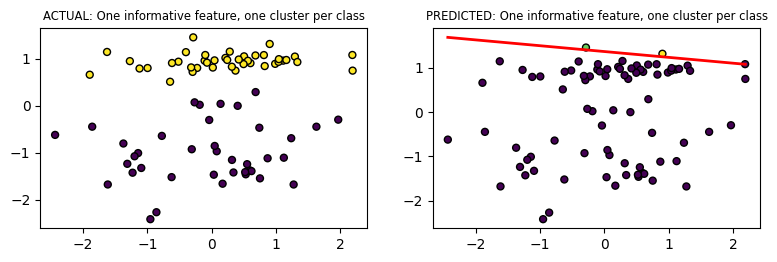

In [11]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Subplot for train data (Top Left)
plt.subplot(3, 2, 1)  # Use subplot grid (3 rows, 2 columns, position 1)
plt.title("ACTUAL: One informative feature, one cluster per class", fontsize="small")
plt.scatter(train_x[:, 0], train_x[:, 1], marker="o", c=train_y, s=25, edgecolor="k")

# Subplot for predicted data (Top Right)
plt.subplot(3, 2, 2)  # Use subplot grid (3 rows, 2 columns, position 2)
plt.title("PREDICTED: One informative feature, one cluster per class", fontsize="small")
plt.scatter(points[:, 0], points[:, 1], marker="o", c=predicted, s=25, edgecolor="k")

# Assuming the equation is y = mx + b (obtained from the model)
# Define range of x-values (adjust based on your data)
x_range = np.linspace(min(points[:, 0]), max(points[:, 0]), 100)
# Calculate predicted y-values for the range
predicted_y = -(weights[0]/weights[1]) * x_range - (bias/ weights[1])
# Overlay the line on the predicted data scatter plot
plt.plot(x_range, predicted_y, color='red', linewidth=2)

print('predicted',predicted)
print('f(x) = w1*x1 + w2*x2 + b')
print('f(x) = '+str(weights[0])+'*x1 + '+str(weights[1])+'*x2 + ' + str(bias))
# print('points.shape',points.shape)
# print('predicted.shape',predicted.shape)
# print('train_x.shape',train_x.shape)
# print('train_y.shape',train_y.shape)


# TODO COMPLETED: draw last iteration MLP predictions on training set on graph stopped here
  # I want to see the function that its learning
  # Since the function that my network is able to learn is linear it does not look like
  # it can learn what is displayed on the graph
  # equation is f(x) = w1*x1 + w2*x2 + b

### Draft 4 New and Improved **Perceptron**: 100% on test set!!
* Since its a Perceptron I couldn't use back prop it didn't work effectively for some reason?? I had to use the Perceptron Convergence Theorem.
  - Investigate why back prop does not work for Perceptrons?

In [12]:
def relu(x):
  if(x<=0):
    return 0
  return 1

# Parameter Initialization
np.random.seed(1)
weights = np.random.randn(2,)
bias = np.random.randn(1)[0]

# Training
m = len(train_x)
print('len(train_x)',m)
iterations = 300
lr = 0.001
points = []
predicted = []
raw_predicted = []
weights_changed = []
bias_changed = []
accuracy = []
for n in range(iterations):
  correct = 0
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2 + bias
    output_relu = relu(output)
    # Perform Loss Calculation
    error = (train_y[i] - output_relu)
    raw_predicted.append(output)
    # predicted.append(output_relu)
    if(error<0.5 and error > -0.5):
      correct += 1
    if(n == iterations-1):
      points.append(train_x[i])
      predicted.append(output_relu)
    # Perform Perceptron Convergence Theorem for Learning
    # Instead of backpropagation!
    weights[0] += lr*error *x1
    weights[1] += lr*error *x2
    bias += lr*error
    if(error != 0):
      weights_changed.append(copy.deepcopy(weights))
      bias_changed.append(bias)
  accuracy.append(correct/m)
  if(n%20== 0 or n == iterations-1):
    # print('error',error)
    print('weights',weights)
    print('----'*10)
    print('At the end of iteration:')
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',weights)
    print('bias',bias)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)

points = np.array(points)
predicted = np.array(predicted)


len(train_x) 80
weights [ 1.60411273 -0.56337181]
----------------------------------------
At the end of iteration:
n:0 Train Accuracy:0.375
weights [ 1.60411273 -0.56337181]
bias -0.5201717522634557
Sample input [ 0.03261455 -1.46754119]
Sample output f(x)=w1*x1 + w2*x2 + b -->  0.36207173936412085
weights [1.15237067 0.20145691]
----------------------------------------
At the end of iteration:
n:20 Train Accuracy:0.625
weights [1.15237067 0.20145691]
bias -0.3981717522634556
Sample input [ 0.03261455 -1.46754119]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -0.6562340149590731
weights [0.76353367 0.55454839]
----------------------------------------
At the end of iteration:
n:40 Train Accuracy:0.7875
weights [0.76353367 0.55454839]
bias -0.27617175226345547
Sample input [ 0.03261455 -1.46754119]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -1.0650920461435707
weights [0.48870806 0.69799022]
----------------------------------------
At the end of iteration:
n:60 Train Accuracy:0.8875
weights 

weights_changed [ 1.6240302  -0.61060325]
[0.10414132 0.76064855]
bias_changed
-0.5291717522634557
-0.2931717522634555
length of predicted 24000


ValueError: x and y must have same first dimension, but have shapes (80,) and (240,)

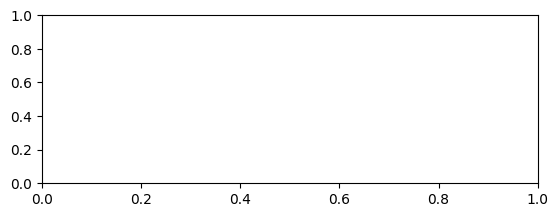

In [13]:
print('weights_changed', weights_changed[0])
print(weights_changed[len(weights_changed)-1])
print('bias_changed')
print(bias_changed[0])
print(bias_changed[len(bias_changed)-1])
print('length of predicted',len(raw_predicted))

x = list(range(80))
y = [np.mean(raw_predicted[i:i+100]) for i in range(0, len(raw_predicted), 100)]

# Create the plot
plt.subplot(2,1,1)
# plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b')

plt.subplot(2,1,2)
x = list(range(100))
plt.plot(x, accuracy, marker='o', linestyle='-', color='b')

# Add title and labels
plt.title('Mean Line Graph')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
# Test on test set
m_test = len(test_x)
correct=0
for i in range(m_test):
  x1 = test_x[i][0]
  x2 = test_x[i][1]
  output = weights[0]*x1 + weights[1]*x2 + bias
  output_relu = relu(output)
  # Perform Loss Calculation
  error = (test_y[i] - output_relu)
  # print('error',error)
  if(error<0.5 and error > -0.5):
    correct += 1
print(str(correct/m_test))

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Subplot for train data (Top Left)
plt.subplot(3, 2, 1)  # Use subplot grid (3 rows, 2 columns, position 1)
plt.title("ACTUAL: One informative feature, one cluster per class", fontsize="small")
plt.scatter(train_x[:, 0], train_x[:, 1], marker="o", c=train_y, s=25, edgecolor="k")

# Subplot for predicted data (Top Right)
plt.subplot(3, 2, 2)  # Use subplot grid (3 rows, 2 columns, position 2)
plt.title("PREDICTED: One informative feature, one cluster per class", fontsize="small")
plt.scatter(points[:, 0], points[:, 1], marker="o", c=predicted, s=25, edgecolor="k")

# Assuming the equation is y = mx + b (obtained from the model)
# Overlay the line on the predicted data scatter plot
x_range = np.linspace(min(points[:, 0]), max(points[:, 0]), 100)
predicted_y = -(weights[0]/weights[1]) * x_range - (bias/ weights[1])
plt.plot(x_range, predicted_y, color='red', linewidth=2)
plt.show()
print('predicted_y',predicted_y)

# print('predicted',predicted)
print('f(x) = w1*x1 + w2*x2 + b')
print('f(x) = '+str(weights[0])+'*x1 + '+str(weights[1])+'*x2 + ' + str(bias))

### Draft 5 Perceptron Implemented using Micrograd framework
* Same as draft 4 but using Neuron and Value implementations from Micrograd

In [ ]:
# Parameter Initialization
np.random.seed(1)
nn = Neuron(nin=train_x[1].shape[0])

# Training
m = len(train_x)
print('len(train_x)',m)
iterations = 100
points = []
predicted = []

for n in range(iterations):
  correct = 0
  for i in range(m):
    output = nn(train_x[i])
    # output = weights[0]*x1 + weights[1]*x2 + bias
    # output_relu = relu(output)

    # Perform Loss Calculation
    # print('output',output)
    # print('train_y[i]',train_y[i])
    error = (train_y[i] - output)
    # print('error',error)
    # print('error',error)
    # raw_predicted.append(output)
    # predicted.append(output_relu)
    if(error.data<0.5 and error.data > -0.5):
      correct += 1
    if(n == iterations-1):
      points.append(train_x[i])
      predicted.append(output.data)

    # Perform Backward()
    nn.backward(train_x[i],error.data)
    # error.backward()
    # weights[0] += lr*error *x1
    # weights[1] += lr*error *x2
    # bias += lr*error

  if(n%20 == 0 or n == iterations-1):
    print('----'*10)
    print('At the end of iteration:')
    print('error',error)
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',nn.w)
    print('bias',nn.b)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)

points = np.array(points)
predicted = np.array(predicted)


## Using existing SKlearn MLP Implementation

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(1,)).fit(train_x, train_y)

In [ ]:
clf.score(test_x, test_y)

In [ ]:
clf.predict(test_x)

In [ ]:
print('test_y',test_y)

# Second Attempt Will Actually use Multi-Layer Perceptron(MLP)
* Solve previous training set and MNIST

### Imports for this section

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

import copy

np.random.seed(1)

### Micrograd Implementation for MLP

In [16]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Value(Module):
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

# Multi Layer Perceptron Implementation
class Neuron(Module):
  '''
  '''
  def __init__(self, nin, nonlin=True):
        self.w = [Value(value)for value in np.random.randn(nin)]
        self.b = Value(np.random.randn(1)[0])
        self.nonlin = nonlin

  def __call__(self, x):
      act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
      return act.relu() if self.nonlin else act

  def parameters(self):
      return self.w + [self.b]

  def __repr__(self):
      return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

  # def backward(self,x,error,lr=0.001):
  #   '''
  #   Define Neuron's backward as Perceptron convergence theorem
  #   '''
  #   for i in range(len(self.w)):
  #       self.w[i] += x[i]*lr*error
  #   self.b += lr*error

### Linear Training Data for MLP

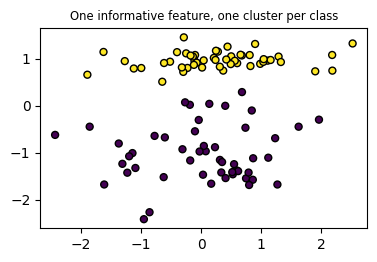

In [17]:
# Linear Training data
# Display Dataset to Train

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

plt.subplot(321)
plt.title("One informative feature, one cluster per class", fontsize="small")
X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1
)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

# Import Dataset to Train
train_length = int(len(X1) * 0.8)
test_length = len(X1) - train_length
train_x, test_x, train_y, test_y = X1[0:train_length], X1[train_length:], Y1[0:train_length], Y1[train_length:]

### Draft 1 My MLP Implementation: Hopefully it goes on to one day solve MNIST

In [ ]:
# Parameter Initialization
np.random.seed(1)
lr = 0.01
iterations = 50
# sizes of layers
# this is a 2 layer network with 2 inputs in the first layer
  # a hidden layer and output layer = 2
  # input layer does not count as a layer.
nouts = [2,16,16,1]
  # 1st layer has 16 neurons with each neuron taking in 2 inputs
  # 2nd layer also has 16 neurons with each neuron taking in 16 inputs
  # 3rd layer is output layer and it takes in 16 inputs and has one output(so one neuron)
  # each neuron gives a single output with each neuron having the equation:
      # (w1*x1 + w2*x2 + ... wn*xn + b = answer)
  # why would an architecture like this be helpful???
mlp = [[Neuron(nin=nouts[i]) for _ in range(nouts[i+1])] for i in range(len(nouts)-1)]

# print(mlp)
# type(mlp)

# linear training data
# print(train_x.shape)
# print(train_y.shape)

# Training Loop
for k in range(iterations):
  correct = 0
  for i in range(len(train_x)):
    input = train_x[i]
    expected_output = train_y[i]
    # forward prop
    for layer in mlp:
      input = [n(input) for n in layer]
    # define a loss function
    loss=(expected_output-input[0])
    if(loss.data < 0.5 and loss.data > -0.5):
      correct += 1
    # backprop
    loss.zero_grad()
    loss.backward()
    # update
    for layer in mlp:
      for n in layer:
        for p in n.parameters():
          p.data += lr * p.grad
  if(k%10==0 or k==iterations-1):
    print('iteration:'+str(k)+' accuracy:'+str(correct/len(train_x)))

### Draft 2: Fix bugs. Get past 50% accuracy. Make it faster???

In [39]:
# Parameter Initialization
np.random.seed(1)
lr = 0.001
iterations = 100
# sizes of layers
# this is a 2 layer network with 2 inputs in the first layer
  # a hidden layer and output layer = 2
  # input layer does not count as a layer.
nouts = [2,1,1]
  # 1st layer has 16 neurons with each neuron taking in 2 inputs
  # 2nd layer also has 16 neurons with each neuron taking in 16 inputs
  # 3rd layer is output layer and it takes in 16 inputs and has one output(so one neuron)
  # each neuron gives a single output with each neuron having the equation:
      # (w1*x1 + w2*x2 + ... wn*xn + b = answer)
  # why would an architecture like this be helpful???
mlp = [[Neuron(nin=nouts[i]) for n_i in range(nouts[i+1])] for i in range(len(nouts)-1)]

# print(mlp)
# type(mlp)

# linear training data
# print(train_x.shape)
# print(train_y.shape)

# Training Loop
for k in range(iterations):
  correct = 0
  for i in range(len(train_x)):
    input = train_x[i]
    expected_output = train_y[i]
    # forward prop
    for layer in mlp:
      input = [n(input) for n in layer]
    # print('input',input)
    # define a loss function
    loss=(expected_output-input[0])
    # print('loss',loss)
    if(loss.data < 0.5 and loss.data > -0.5):
      correct += 1
    # backprop
      # zero out gradient for each update of network
      # so we don't carry over gradient from previous example
    loss.zero_grad()
    loss.backward()
    # update
    for layer in mlp:
      for n in layer:
        for p in n.parameters():
          p.data += lr * p.grad
          # print('p.grad',p.grad)
  if(k%10==0 or k==iterations-1):
    print('iteration:'+str(k)+' accuracy:'+str(correct/len(train_x)))

iteration:0 accuracy:0.5125
iteration:10 accuracy:0.4875
iteration:20 accuracy:0.4875
iteration:30 accuracy:0.4875
iteration:40 accuracy:0.4875
iteration:50 accuracy:0.4875
iteration:60 accuracy:0.4875
iteration:70 accuracy:0.4875
iteration:80 accuracy:0.4875
iteration:90 accuracy:0.4875
iteration:99 accuracy:0.4875
